In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle
import copy

from tqdm import tqdm


pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

%run SodaKick_download_functions.ipynb


import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adagrad, Adam
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class EarlyStopping:

    """ Stops the training if loss doesn't improve after a given number of epochs. """

    def __init__(self, patience=3, epsilon=1e-5, keepBest=True, silent=True):

        """
        Args:
            patience (int): Number of epochs without change before stopping the learning (default 3).
            epsilon (float): Minimum change in loss to be considered for early stopping (default 1e-5).
            keepBest (bool): Keep track of the best model (memory consuming).
        """

        self.patience = patience
        self.epsilon = epsilon
        self.counter = 0
        
        self.bestScore = np.inf
     
        self.keepBest = keepBest 
        self.bestModel = None

        self.earlyStop = False
        self.silent = silent

    def __call__(self, loss, model):


        """ Evaluate the loss change between epochs and activates early stop if below epsilon.

        Args:
            loss (float): current loss.
            model (torch model): the current model.
        """

        if loss > self.bestScore - self.epsilon:

            self.counter += 1
            if not self.silent:
                print('EarlyStopping counter: {:d}/{:d}'.format(self.counter,self.patience))

            if self.counter >= self.patience:
                self.earlyStop = True

        else:   

            self.counter = 0
            self.bestScore = loss

            if self.keepBest:
                self.bestModel = copy.deepcopy(model)


In [3]:
class matchesDataset(Dataset):

    """ Extend pytorch Dataset class to include cleaning and training set creation, """
    
    def __init__(self, matches, results):

        self.matches = torch.tensor(matches, dtype=torch.float32)
        self.results = torch.tensor(results, dtype=torch.float32)

    def __len__(self):

        """ Returns the len of the training sample. """
        
        return len(self.matches)
        

    def __getitem__(self, index): 

        """ Returns a word, a context word and a list of negative words for training for a given index. 

        Args:
            index (int): index for the word selection.

        Returns:
            (string, string, list of strings): selected word, context word and a randomly drawn list 
                                               of negative words.

        """
        return self.matches[index], self.results[index]
    
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 4}

In [4]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

In [5]:
from sklearn import preprocessing

#with open(r'/Users/federico comitani/GitHub/sodakick/data/SA2021_inp_tsvd.pkl', 'rb') as pk:
#    inp_tsv=pickle.load(pk)
#with open(r'/Users/federico comitani/GitHub/sodakick/data/SA2021_out_tsvd.pkl', 'rb') as pk:
#    out_tsv=pickle.load(pk)
#with open(r'/Users/federico comitani/GitHub/sodakick/data/SA2021_inp.pkl', 'rb') as pk:
#    inp=pickle.load(pk)
#with open(r'/Users/federico comitani/GitHub/sodakick/data/SA2021_out.pkl', 'rb') as pk:
#    out=pickle.load(pk)
    
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_a.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_a.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_b.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_b.pkl', 'rb') as pk:
    outb=pickle.load(pk)     
    
    
#no point in not using tsvd

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90
        
normalize_mins(out)



scaler = preprocessing.StandardScaler().fit(inp)
inp = scaler.transform(inp)

In [6]:
#from sklearn.model_selection import train_test_split as tts
#x_train, x_test, y_train, y_test = tts(inp, out, test_size=0.33, random_state=32)

In [7]:
"""class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = torch.sigmoid(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z

net = Net()"""

'class Net(nn.Module):\n    \n    def __init__(self):\n        super(Net, self).__init__()\n        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])\n        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])\n    \n    def forward(self, x):\n        z = torch.sigmoid(self.hid1(x)) #tanh original\n        z = self.oupt(z)  \n        # no softmax. see CrossEntropyLoss() \n        #you can return the loss if you wish here (see skipgram)\n        return z\n\nnet = Net()'

In [8]:
#epochs=50
#optimizer = Adagrad(net.parameters(), lr=0.1)
#loss_func = WSE#nn.MSELoss() #nn.L1Loss()
#earlStop = EarlyStopping(patience=3, keepBest=False)

def train(x_train, y_train, x_test, y_test, net, optimizer, loss_func, epochs, earlStop, clip=False, silent=True):
    
    phases = ['train']
    
    training_set = matchesDataset(x_train, y_train)
    trainBatch = torch.utils.data.DataLoader(training_set, **params)

    if x_test is not None and y_test is not None:
        phases.append('val')
        validation_set = matchesDataset(x_test, y_test)
        valBatch = torch.utils.data.DataLoader(validation_set, **params)

    losses=[[],[]]
    mses=[]
    diffs=[]
    exit=False
    #for epoch in tqdm(range(epochs), desc='Epoch'):
    for epoch in range(epochs):

        if exit:
            break
            
        for phase in phases:
            if phase == 'train':
                net.train(True)  # Set model to training mode

                """ Run the training of the model. """    

                losses_batch=[]
                mses_batch=[]
                diff_batch=[]
                #pBarB = tqdm(enumerate(trainBatch), total=len(trainBatch),  desc='Batch')
                #for batchNum, batch in pBarB:
                for batchNum, batch in enumerate(trainBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """
                    
                    loss = loss_func(net(x), y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if clip:
                        net.clp()

                    losses_batch.append(loss)
                    #pBarB.set_postfix({'train loss' : '{:.5f}'.format(loss.item())})

                """ Early stop check. """

                earlStop(loss, net)
                finalepoch = epoch
                
                if earlStop.earlyStop:

                    if not silent:
                        print('Limit loss improvement reached, stopping the training.')
                        
                    exit=True 
                
                losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
            else:
                net.train(False)
                net.eval()
      
                losses_batch=[]
                #pBarB = tqdm(enumerate(valBatch), total=len(valBatch),  desc='Batch')
                #for batchNum, batch in pBarB:
                for batchNum, batch in enumerate(valBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    loss = loss_func(net(x), y)

                    optimizer.zero_grad()
                    output=net(x)
                    target=y
                    mses_batch.append(torch.mean(torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      torch.maximum(torch.zeros(output.shape[1]),output - target)**2)  )
                    losses_batch.append(loss)
                    diff_batch.append(output-target)
                    
                    
                    #pBarB.set_postfix({'val loss' : '{:.5f}'.format(loss.item())})
                losses[1].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                mses.append(torch.mean(torch.stack(mses_batch)).detach().cpu().numpy())
                diffs.append(torch.mean(torch.cat(diff_batch, dim=0), dim=0).detach().cpu().numpy())
        
    return losses, finalepoch, mses, diffs, net

In [9]:
#plt.plot(losses[0], label='training')
#plt.plot(losses[1], label='validation')

In [10]:
#with open(r'/Users/federico comitani/GitHub/sodakick/data/SA2021_lineups.pkl', 'rb') as pk:
#    lineups=pickle.load(pk)
#with open(r'/Users/federico comitani/GitHub/sodakick/data/SA2021_out.pkl', 'rb') as pk:
#    out=pickle.load(pk)

In [20]:
def revert_output(output,lineup):

    reframe=pd.DataFrame(output.reshape(50,8), index=lineup.index,
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
    byteamframe=pd.concat([reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==0].index]].sum(axis=0),
                        reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==1].index]].sum(axis=0)], axis=1).T
    
    reframe['minutes']=reframe['minutes']*90
    
    return reframe, byteamframe[byteamframe.columns[1:]]
    

In [21]:
"""i=0

b4, b4t = revert_output(out[i], lineups[i])
a4, a4t = revert_output(net(torch.tensor(inp_tsv[i], dtype=torch.float32)).detach().cpu().numpy(),lineups[i])

print(a4)
print(b4)
print()

print(a4t)
print(b4t)
print()
"""

'i=0\n\nb4, b4t = revert_output(out[i], lineups[i])\na4, a4t = revert_output(net(torch.tensor(inp_tsv[i], dtype=torch.float32)).detach().cpu().numpy(),lineups[i])\n\nprint(a4)\nprint(b4)\nprint()\n\nprint(a4t)\nprint(b4t)\nprint()\n'

# cross valid

In [40]:
class Net1(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = torch.sigmoid(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))
            
class Net2(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net2, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.hid2 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = torch.sigmoid(self.hid2(self.hid1(x))) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
                          
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.hid2.weight.copy_ (self.hid2.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))
            
class Net3(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net3, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1]*2)
        self.oupt = nn.Linear(x_train.shape[1]*2, y_train.shape[1])
    
    def forward(self, x):
        z = torch.sigmoid(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))
    
class Net4(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net4, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lrl1 = torch.nn.LeakyReLU()
        self.hid2 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lrl2 = torch.nn.LeakyReLU()
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = self.hid1(x)
        z = self.lrl1(z)
        z = self.hid2(z) #tanh original
        z = self.lrl2(z)
        z = self.oupt(z)
        #z = torch.maximum(torch.zeros(z.shape[1]),z)
        return z
    
    def clp(self):
        with torch.no_grad():
            #self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            #self.hid2.weight.copy_ (self.hid2.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0)) 
            
class Net1max(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1max, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = torch.sigmoid(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        z = torch.maximum(torch.zeros(z.shape[1]),z)
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))
            
            
class Net1tan(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1tan, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = torch.tanh(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    
class Net1lrelu(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1lrelu, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lrl1 = torch.nn.LeakyReLU()
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
        
    def forward(self, x):
        z = self.lrl1(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    
class Net1dp(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1dp, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.dp = nn.Dropout(p=0.2)
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = self.dp(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
        
class Net1bn(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1bn, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.bn = torch.nn.BatchNorm1d(x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = self.bn(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
class Cnn1(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Cnn1, self).__init__()
        self.conv1 = nn.Conv1d(1, 3, 3)
        self.lrl1 = torch.nn.LeakyReLU()
        self.pool = nn.MaxPool1d(2)
        self.hid1 = nn.Linear(1722, 1000)
        self.dp = nn.Dropout(p=0.2)
        self.lrl2 = torch.nn.LeakyReLU()
        self.oupt = nn.Linear(1000, y_train.shape[1])
    
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = self.pool(self.lrl1(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.lrl2(self.hid1(x))
        x = self.oupt(x)
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return x   
    
    
class Cnn2(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Cnn2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3)
        self.lrl1 = torch.nn.LeakyReLU()
        self.pool = nn.MaxPool1d(2)
        self.hid1 = nn.Linear(9184, 1000)
        self.dp = nn.Dropout(p=0.2)
        self.lrl2 = torch.nn.LeakyReLU()
        self.oupt = nn.Linear(1000, y_train.shape[1])
    
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = self.pool(self.lrl1(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.lrl2(self.hid1(x))
        x = self.oupt(x)
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return x
    
class Cnn3(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Cnn3, self).__init__()
        self.conv1 = nn.Conv1d(1, 3, 3)
        self.lrl1 = torch.nn.LeakyReLU()
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(3, 9, 3)
        self.lrl2 = torch.nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.hid1 = nn.Linear(2574, 1000)
        self.dp = nn.Dropout(p=0.2)
        self.lrl3 = torch.nn.LeakyReLU()
        self.oupt = nn.Linear(1000, y_train.shape[1])
    
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = self.pool(self.lrl1(self.conv1(x)))
        x = self.pool2(self.lrl2(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.lrl3(self.hid1(x))
        x = self.oupt(x)
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return x
    
    
class Net2lrelu(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net2lrelu, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lrl1 = torch.nn.LeakyReLU()
        #self.bn1 = torch.nn.BatchNorm1d(x_train.shape[1])
        self.hid2 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lrl2 = torch.nn.LeakyReLU()
        #self.bn2 = torch.nn.BatchNorm1d(x_train.shape[1])
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
        
    def forward(self, x):
        #z = self.bn1(self.lrl1(self.hid1(x))) #tanh original
        #z = self.bn2(self.lrl2(self.hid2(z)))
        z = self.lrl1(self.hid1(x)) #tanh original
        z = self.lrl2(self.hid2(z))
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
class Netsmol(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Netsmol, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], int(x_train.shape[1]/2))
        self.lrl1 = torch.nn.LeakyReLU()
        #self.bn1 = torch.nn.BatchNorm1d(int(x_train.shape[1]/2))
        self.oupt = nn.Linear(int(x_train.shape[1]/2), y_train.shape[1])
        
    def forward(self, x):
        #z = self.bn1(self.lrl1(self.hid1(x))) #tanh original
        z = self.lrl1(self.hid1(x)) #tanh original
        z = self.oupt(z)  
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
def conv_out_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):

	if isinstance(h_w, list):
	    if type(kernel_size) is not tuple:
	        kernel_size = (kernel_size, kernel_size)
	    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
	    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
	    return h, w
	else:
		return floor( ((h_w + (2 * pad) - ( dilation * (kernel_size - 1) ) - 1 )/ stride) + 1)

In [44]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, model, loss_func, clip=False, epochs=100):
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(indata)
    

    losses=[]
    ec=[]
    mss=[]
    diffs=[]
    for train_index, test_index in kf.split(inp):
        earlStop = EarlyStopping(patience=10, keepBest=False)
        net = model(indata, outdata)
        optimizer = Adam(net.parameters(), lr=0.01)
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]
        
        #standardize data
        x_train -= x_train.min(1)[0]
        x_train /= x_train.max(1)[0]
        x_test -= x_test.min(1)[0]
        x_test /= x_test.max(1)[0]
        
        
        ls, ep, ms, df, net = train(x_train, y_train, x_test, y_test, net=net, optimizer=optimizer, loss_func=loss_func, epochs=epochs, earlStop=earlStop, clip=clip)
        losses.append(ls[1])
        ec.append(ep)
        mss.append(ms)
        diffs.append(df)
        
        errs=[np.mean([np.mean(x.reshape(-1, 50), axis=1) for x in diffs[y]], axis=0) for y in range(len(diffs))]
        meaerrs=np.mean(errs, axis=0)
        meastd=np.std(errs, axis=0)
        
    print('Epochs: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    print('MSE Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in mss]),np.std([np.mean(x) for x in mss])))
    return losses, net, meaerrs, meastd

In [27]:
#ls1=runKfold(inp, out, Net1, WSE)
#ls2=runKfold(inp, out, Net2, WSE)
#ls3=runKfold(inp, out, Net3, WSE)
#print()
#ls11=runKfold(inp, out, Net1, nn.MSELoss())
#ls12=runKfold(inp, out, Net2, nn.MSELoss())
#ls13=runKfold(inp, out, Net3, nn.MSELoss())
#print()
def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print()
#lst1, nt1=runKfold(inp, out, Net1, WSE)
#lst2, nt2=runKfold(inp, out, Net2, WSE)
#lst3, nt3=runKfold(inp, out, Net3, WSE)
#lst4, nt4=runKfold(inp, out, Net4, WSE)
#print()
#lst11, nt11=runKfold(inp, out, Net1, WSEl1)
#lst12, nt12=runKfold(inp, out, Net2, WSEl1)
#lst13, nt13=runKfold(inp, out, Net3, WSEl1)
#lst14, nt14=runKfold(inp, out, Net4, WSEl1)
print()
#lst21, nt21=runKfold(inp, out, Net1, nn.MSELoss())
#lst22, nt22=runKfold(inp, out, Net2, nn.MSELoss())
#lst23, nt23=runKfold(inp, out, Net3, nn.MSELoss())
#lst24, nt24=runKfold(inp, out, Net4, nn.MSELoss())
print()
#lstc1, ntc1=runKfold(inp, out, Net1, WSE, clip=True)
#lstc31, ntc31=runKfold(inp, out, Net1, nn.MSELoss(), clip=True)
print()
#lst1l, nt1l=runKfold(inp, out, Net1max, nn.MSELoss())
#lst1l, nt1l=runKfold(inp, out, Net1tan, nn.MSELoss())
#lst1l, nt1l=runKfold(inp, out, Net1lrelu, nn.MSELoss())
print()
#lst1l, nt1l=runKfold(inp, out, Net1dp, WSE)
#lst1l, nt1l=runKfold(inp, out, Net1dp, nn.MSELoss())
print()
#lst1l, nt1l=runKfold(inp, out, Cnn1, nn.MSELoss())
#lst1l, nt1l=runKfold(inp, out, Cnn2, nn.MSELoss())
#lst1l, nt1l=runKfold(inp, out, Cnn3, nn.MSELoss())
print()
#lst1l, nt1l=runKfold(inp, out, Net1lrelu, WSE)
#lst1l, nt1l=runKfold(inp, out, Net1lrelu, nn.MSELoss())

Baseline WSE: 0.230
Baseline WSE l1: 0.139
Baseline MSE: 0.153
Baseline MSE l1: 0.092








Epochs: 16.800+/-4.874
KFold Result: 0.060+/-0.003
MSE Result: 0.069+/-0.012


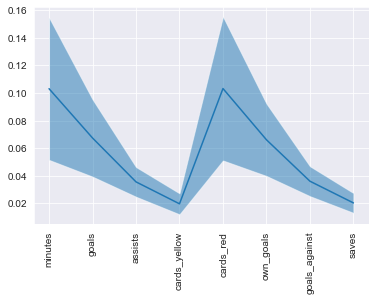

Epochs: 17.200+/-6.274
KFold Result: 0.054+/-0.003
MSE Result: 0.054+/-0.003


([<matplotlib.axis.XTick at 0x1a4fa0be10>,
 [Text(0, 0, 'minutes'),
  Text(0, 0, 'goals'),
  Text(0, 0, 'assists'),
  Text(0, 0, 'cards_yellow'),
  Text(0, 0, 'cards_red'),
  Text(0, 0, 'own_goals'),
  Text(0, 0, 'goals_against'),
  Text(0, 0, 'saves')])

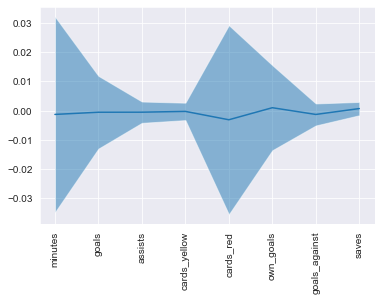

In [153]:
lst1s, nt1s, errmea, errstd=runKfold(inp, out, Netsmol, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Netsmol, nn.MSELoss())
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)

Epochs: 19.000+/-7.127
KFold Result: 0.055+/-0.003
MSE Result: 0.062+/-0.001


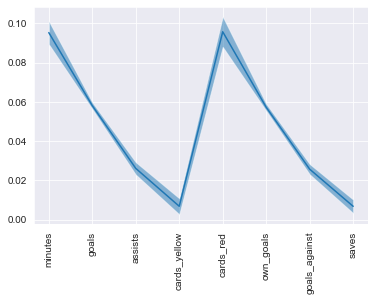

Epochs: 13.600+/-3.382
KFold Result: 0.055+/-0.003
MSE Result: 0.063+/-0.001


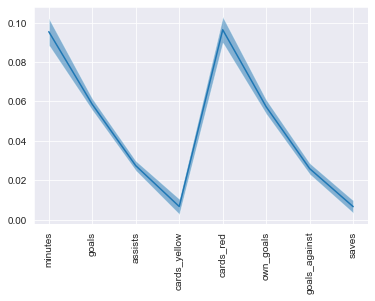

Epochs: 24.600+/-4.630
KFold Result: 0.059+/-0.004
MSE Result: 0.062+/-0.002


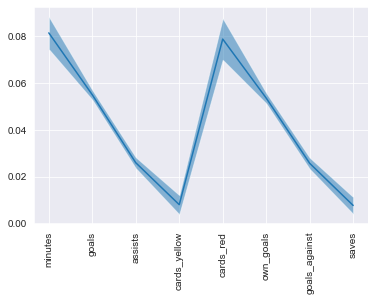

Epochs: 17.200+/-4.578
KFold Result: 0.068+/-0.020
MSE Result: 0.081+/-0.028


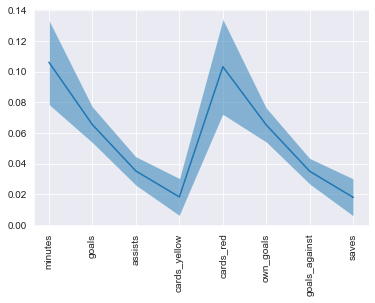

In [35]:
lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net2, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net3, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net4, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

Epochs: 12.000+/-3.033
KFold Result: 0.064+/-0.005
MSE Result: 0.078+/-0.003


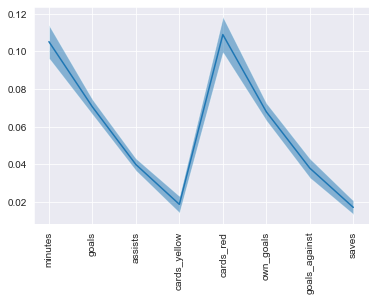

Epochs: 20.000+/-2.280
KFold Result: 0.139+/-0.026
MSE Result: 0.106+/-0.014


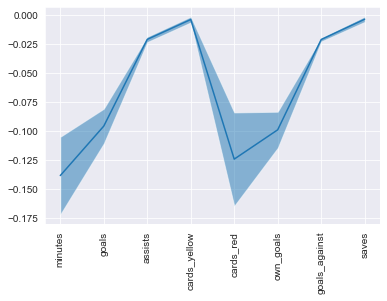

Epochs: 10.400+/-0.490
KFold Result: 0.172+/-0.006
MSE Result: 0.232+/-0.018


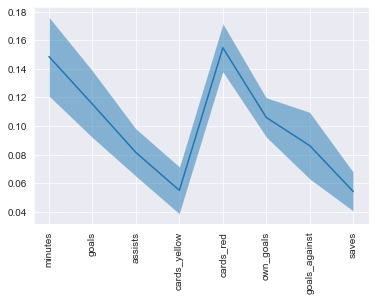

Epochs: 21.000+/-3.899
KFold Result: 0.065+/-0.010
MSE Result: 0.073+/-0.008


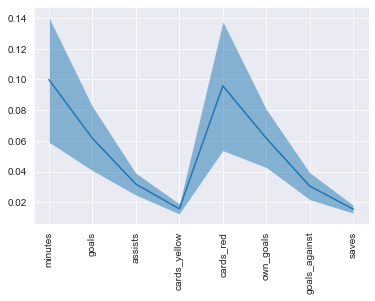

Epochs: 20.400+/-10.327
KFold Result: 0.060+/-0.002
MSE Result: 0.069+/-0.008


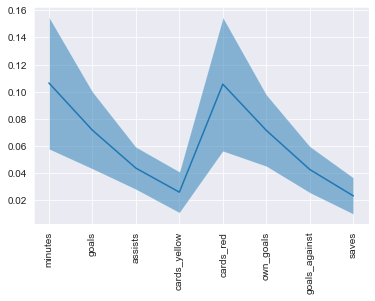

In [42]:
lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1, WSE, clip=True)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1max, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1tan, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1lrelu, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()


lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net2lrelu, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

Epochs: 26.200+/-4.874
KFold Result: 0.329+/-0.348
MSE Result: 0.541+/-0.632


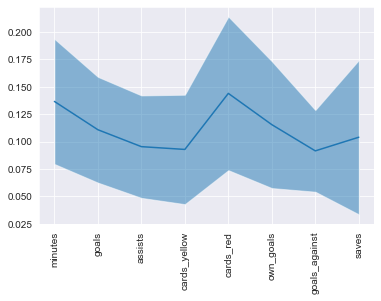

Epochs: 22.800+/-5.741
KFold Result: 1.013+/-1.320
MSE Result: 1.020+/-1.252


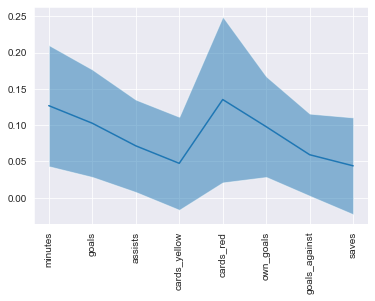

In [41]:
lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1dp, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

lst1s, nt1s, errmea, errstd=runKfold(inp, out, Net1bn, WSE)
plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

In [55]:
#issue with the zeroes
#alternative activation function
#optimize loss
#architectures?
#add player role


#keep years as separate channels for cnn

In [46]:
def final_training(indata, outdata, model, loss_func, clip=False, epochs=100):

    earlStop = EarlyStopping(patience=10, keepBest=True)
    net = model(indata, outdata)
    optimizer = Adam(net.parameters(), lr=0.01)

    x_train = indata
    y_train = outdata
    
    #standardize data
    x_train -= x_train.min(1)[0]
    x_train /= x_train.max(1)[0]

    ls, ep, ms, df, net = train(x_train, y_train, None, None, net=net, optimizer=optimizer, loss_func=loss_func, epochs=epochs, earlStop=earlStop, clip=clip)

    return net

In [94]:
nt = final_training(inp, out, Net2lrelu, nn.MSELoss())

In [95]:
def revert_output(output,lineup=None):

    reframe=pd.DataFrame(output.reshape(50,8),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
        
    reframe['minutes']*=90
    #byteamframe=pd.concat([reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==0].index]].sum(axis=0),
    #                    reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==1].index]].sum(axis=0)], axis=1).T
    
    byteamframe=pd.concat([reframe.iloc[:25,:].sum(axis=0),reframe.iloc[25:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

In [96]:
pred=nt(torch.Tensor(inp)).detach().cpu().numpy()[0]


cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

#for x in range(len(pred)):
#    print('{:.2f}'.format(pred[x]), end='\t')
#    print('{:.2f}'.format(out[0][x]), end='\t')
#    print(cats[x%len(cats)])
#print(['{:.2f}'.format(x) for x in pred])
#print(out[0])
reframe, byteamframe = revert_output(pred)
#print(reframe)
print(byteamframe)
reframe, byteamframe = revert_output(out[0])
#print(reframe)
print(byteamframe)

         goals      assists  cards_yellow    cards_red    own_goals  \
0  1426.938232  1831.158569    1731.81543  1410.931519   998.651245   
1  1358.784302  1084.465210    1670.96521  1188.346924  1258.031250   

   goals_against        saves  
0    1098.115112  1137.431152  
1    1625.426514   904.332092  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    1.0      1.0           3.0        0.0        0.0            0.0    3.0
1    0.0      0.0           1.0        0.0        0.0            1.0    5.0


In [92]:
print(nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10])
#f*ck it's learning the averages... not really working...

"""
    Dead ReLU(s) in the network
    Vanishing gradient issues
    In correct weights initialization
    Weights are either getting saturated or deminished
    Data is not properly pre-processes like normalized, scaled, zero-centered
    The depth and/or width is inadequate for the input data
    There is a logic bug in the code"""

[ 2.63844727e+02  3.85324287e+00  6.11265945e+00  3.28732300e+00
 -3.01519585e+00  3.66831017e+00 -2.93324900e+00 -2.47863436e+00
  2.63399902e+02  3.79093742e+00  5.61685562e+00 -4.04890823e+00
  3.05528831e+00 -3.70143795e+00 -2.87607384e+00 -2.91484547e+00
  2.64077148e+02 -3.13850784e+00 -3.94458389e+00 -2.36749029e+00
 -2.27320576e+00 -2.61442947e+00 -3.47148132e+00  1.89588261e+00
  2.62336914e+02 -3.60831738e+00  3.37891006e+00 -3.25490952e+00
 -2.19927788e+00  2.96157026e+00 -4.86666679e+00 -2.75225830e+00
  2.43264648e+02 -4.09491682e+00  1.97351885e+00 -3.26905918e+00
 -2.30619287e+00  4.56172562e+00 -2.23787689e+00 -4.02520561e+00
  2.63709961e+02 -1.82353401e+00 -6.12717438e+00 -3.58916378e+00
 -2.96664333e+00 -2.20281219e+00 -6.12757874e+00 -2.94703007e+00
  2.25326172e+02 -2.93043137e+00  2.79467988e+00 -3.24998975e+00
  3.56717110e+00  2.71464729e+00  1.66975737e+00 -4.69078255e+00
  1.78292480e+02 -3.28451824e+00 -2.75382042e+00 -4.15689993e+00
  3.48799610e+00 -2.83611

'\n    Dead ReLU(s) in the network\n    Vanishing gradient issues\n    In correct weights initialization\n    Weights are either getting saturated or deminished\n    Data is not properly pre-processes like normalized, scaled, zero-centered\n    The depth and/or width is inadequate for the input data\n    There is a logic bug in the code'